## Importing libraries

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import random
import cv2
import time
from keras import losses
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, Reshape, UpSampling2D, Dense
from keras.layers.merge import concatenate
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.optimizers import Adadelta, SGD, Adam
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from keras.layers import concatenate
from keras.utils.vis_utils import model_to_dot
from keras.utils import np_utils
from IPython.display import SVG
from tqdm import tqdm, tqdm_notebook

Using TensorFlow backend.


## Importing data from CSVs.

In [2]:
features_data = pd.read_csv("15features.csv")
training_data = pd.read_csv("seen-dataset/dataset_seen_training_siamese.csv")
validation_data = pd.read_csv("seen-dataset/dataset_seen_validation_siamese.csv")

training_data = training_data.drop('Unnamed: 0',1)
validation_data = validation_data.drop('Unnamed: 0',1)

train_path = 'seen-dataset/TrainingSet/'
train_images = os.listdir(train_path)

val_path = 'seen-dataset/ValidationSet/'
val_images = os.listdir(val_path)

columns = features_data.columns

#Get the unique no of values a given feature can take.
features_values = []
for i in columns[1:]:
    #print(i)
    features_values.append(features_data[i].unique().shape[0])
features_values

[2, 3, 3, 3, 2, 2, 4, 2, 2, 4, 2, 3, 4, 2, 2]

## Datagen

In [3]:
def datagen(batch_size,image_path,list_of_writers, hshift = (-64,64) ,vis=False):
    counter = 0
    while True:
        counter = 0
        w_ids,ids = [],[]
        writer_indexes = np.random.randint(0,len(list_of_writers),batch_size)
        x,y,writers = [],[],[]
        for writer_index in writer_indexes:
            writer = list_of_writers[writer_index] 
            loaded_image = cv2.imread(os.path.join(image_path,writer),0)
            rand = np.random.randint(hshift[0],hshift[1])
            loaded_image_shifted=np.roll(axis=0,a=loaded_image,shift=rand)
            x.append(255.0-loaded_image_shifted.reshape((64,64,1)))
            y.append(255.0-loaded_image.reshape((64,64,1)))
            w_ids.append(writer[:4])
            writers.append(writer)
            ids.append(writer_index)
            counter+=1
        if counter <= batch_size:
            if vis== True:
                yield np.array(x)/255.0,[np.array(w_ids),np.array(writers)]
            else:
                yield np.array(x)/255.0,np.array(y)/255.0

## AutoEncoder

In [4]:
input_img = Input(shape=(64, 64, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoded')(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same',name='output')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])
autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_

##  Generators

In [5]:
train_list_of_writers = train_images
val_list_of_writers = val_images
batch_size = 64

training_datagen = datagen(batch_size,train_path,train_list_of_writers, hshift = (-10,10))
validation_datagen = datagen(batch_size,val_path,val_list_of_writers, hshift = (-10,10))

## SVG

In [1]:
SVG(model_to_dot(autoencoder, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

NameError: name 'SVG' is not defined

## Model Checkpoint and Early Stopping

In [7]:
mc = ModelCheckpoint(filepath='saved_model_seen_mc.h5', 
                     monitor='val_loss',period=1,save_best_only=True,save_weights_only=True,mode='auto',verbose=3)
es = EarlyStopping(patience=10000, monitor='val_loss', min_delta=0.0005, mode='auto')

## Fitting the generator

In [8]:
EPOCHS = 5000

hist = autoencoder.fit_generator(training_datagen,
                                 callbacks=[mc,es],
                                 epochs=EPOCHS,
                                 steps_per_epoch = 1,
                                 validation_data = validation_datagen,
                                 validation_steps = 1,
                                 verbose = 3)
autoencoder.save_weights("saved_model_seen_mc.h5")
encoder = Model(inputs=autoencoder.inputs,outputs=autoencoder.get_layer('encoded').output)


Instructions for updating:
Use tf.cast instead.
Epoch 1/5000

Epoch 00001: val_loss improved from inf to 0.68769, saving model to saved_model_seen_mc.h5
Epoch 2/5000

Epoch 00002: val_loss improved from 0.68769 to 0.67640, saving model to saved_model_seen_mc.h5
Epoch 3/5000

Epoch 00003: val_loss improved from 0.67640 to 0.65519, saving model to saved_model_seen_mc.h5
Epoch 4/5000

Epoch 00004: val_loss improved from 0.65519 to 0.60282, saving model to saved_model_seen_mc.h5
Epoch 5/5000

Epoch 00005: val_loss improved from 0.60282 to 0.42907, saving model to saved_model_seen_mc.h5
Epoch 6/5000

Epoch 00006: val_loss did not improve from 0.42907
Epoch 7/5000

Epoch 00007: val_loss did not improve from 0.42907
Epoch 8/5000

Epoch 00008: val_loss did not improve from 0.42907
Epoch 9/5000

Epoch 00009: val_loss improved from 0.42907 to 0.36127, saving model to saved_model_seen_mc.h5
Epoch 10/5000

Epoch 00010: val_loss improved from 0.36127 to 0.30292, saving model to saved_model_seen_mc.

Epoch 226/5000

Epoch 00226: val_loss did not improve from 0.16029
Epoch 227/5000

Epoch 00227: val_loss did not improve from 0.16029
Epoch 228/5000

Epoch 00228: val_loss did not improve from 0.16029
Epoch 229/5000

Epoch 00229: val_loss did not improve from 0.16029
Epoch 230/5000

Epoch 00230: val_loss did not improve from 0.16029
Epoch 231/5000

Epoch 00231: val_loss did not improve from 0.16029
Epoch 232/5000

Epoch 00232: val_loss did not improve from 0.16029
Epoch 233/5000

Epoch 00233: val_loss did not improve from 0.16029
Epoch 234/5000

Epoch 00234: val_loss did not improve from 0.16029
Epoch 235/5000

Epoch 00235: val_loss did not improve from 0.16029
Epoch 236/5000

Epoch 00236: val_loss did not improve from 0.16029
Epoch 237/5000

Epoch 00237: val_loss did not improve from 0.16029
Epoch 238/5000

Epoch 00238: val_loss did not improve from 0.16029
Epoch 239/5000

Epoch 00239: val_loss did not improve from 0.16029
Epoch 240/5000

Epoch 00240: val_loss did not improve from 0.1

Epoch 00466: val_loss did not improve from 0.15127
Epoch 467/5000

Epoch 00467: val_loss did not improve from 0.15127
Epoch 468/5000

Epoch 00468: val_loss did not improve from 0.15127
Epoch 469/5000

Epoch 00469: val_loss did not improve from 0.15127
Epoch 470/5000

Epoch 00470: val_loss did not improve from 0.15127
Epoch 471/5000

Epoch 00471: val_loss did not improve from 0.15127
Epoch 472/5000

Epoch 00472: val_loss did not improve from 0.15127
Epoch 473/5000

Epoch 00473: val_loss did not improve from 0.15127
Epoch 474/5000

Epoch 00474: val_loss did not improve from 0.15127
Epoch 475/5000

Epoch 00475: val_loss did not improve from 0.15127
Epoch 476/5000

Epoch 00476: val_loss did not improve from 0.15127
Epoch 477/5000

Epoch 00477: val_loss did not improve from 0.15127
Epoch 478/5000

Epoch 00478: val_loss did not improve from 0.15127
Epoch 479/5000

Epoch 00479: val_loss did not improve from 0.15127
Epoch 480/5000

Epoch 00480: val_loss did not improve from 0.15127
Epoch 481/5

Epoch 00708: val_loss did not improve from 0.14446
Epoch 709/5000

Epoch 00709: val_loss did not improve from 0.14446
Epoch 710/5000

Epoch 00710: val_loss did not improve from 0.14446
Epoch 711/5000

Epoch 00711: val_loss did not improve from 0.14446
Epoch 712/5000

Epoch 00712: val_loss did not improve from 0.14446
Epoch 713/5000

Epoch 00713: val_loss did not improve from 0.14446
Epoch 714/5000

Epoch 00714: val_loss did not improve from 0.14446
Epoch 715/5000

Epoch 00715: val_loss did not improve from 0.14446
Epoch 716/5000

Epoch 00716: val_loss did not improve from 0.14446
Epoch 717/5000

Epoch 00717: val_loss did not improve from 0.14446
Epoch 718/5000

Epoch 00718: val_loss did not improve from 0.14446
Epoch 719/5000

Epoch 00719: val_loss did not improve from 0.14446
Epoch 720/5000

Epoch 00720: val_loss did not improve from 0.14446
Epoch 721/5000

Epoch 00721: val_loss did not improve from 0.14446
Epoch 722/5000

Epoch 00722: val_loss did not improve from 0.14446
Epoch 723/5

Epoch 951/5000

Epoch 00951: val_loss did not improve from 0.14258
Epoch 952/5000

Epoch 00952: val_loss did not improve from 0.14258
Epoch 953/5000

Epoch 00953: val_loss did not improve from 0.14258
Epoch 954/5000

Epoch 00954: val_loss did not improve from 0.14258
Epoch 955/5000

Epoch 00955: val_loss did not improve from 0.14258
Epoch 956/5000

Epoch 00956: val_loss did not improve from 0.14258
Epoch 957/5000

Epoch 00957: val_loss did not improve from 0.14258
Epoch 958/5000

Epoch 00958: val_loss did not improve from 0.14258
Epoch 959/5000

Epoch 00959: val_loss did not improve from 0.14258
Epoch 960/5000

Epoch 00960: val_loss did not improve from 0.14258
Epoch 961/5000

Epoch 00961: val_loss did not improve from 0.14258
Epoch 962/5000

Epoch 00962: val_loss did not improve from 0.14258
Epoch 963/5000

Epoch 00963: val_loss did not improve from 0.14258
Epoch 964/5000

Epoch 00964: val_loss did not improve from 0.14258
Epoch 965/5000

Epoch 00965: val_loss did not improve from 0.1

Epoch 01190: val_loss did not improve from 0.13518
Epoch 1191/5000

Epoch 01191: val_loss did not improve from 0.13518
Epoch 1192/5000

Epoch 01192: val_loss did not improve from 0.13518
Epoch 1193/5000

Epoch 01193: val_loss did not improve from 0.13518
Epoch 1194/5000

Epoch 01194: val_loss did not improve from 0.13518
Epoch 1195/5000

Epoch 01195: val_loss did not improve from 0.13518
Epoch 1196/5000

Epoch 01196: val_loss did not improve from 0.13518
Epoch 1197/5000

Epoch 01197: val_loss did not improve from 0.13518
Epoch 1198/5000

Epoch 01198: val_loss did not improve from 0.13518
Epoch 1199/5000

Epoch 01199: val_loss did not improve from 0.13518
Epoch 1200/5000

Epoch 01200: val_loss did not improve from 0.13518
Epoch 1201/5000

Epoch 01201: val_loss did not improve from 0.13518
Epoch 1202/5000

Epoch 01202: val_loss did not improve from 0.13518
Epoch 1203/5000

Epoch 01203: val_loss did not improve from 0.13518
Epoch 1204/5000

Epoch 01204: val_loss did not improve from 0.135

Epoch 01430: val_loss did not improve from 0.13518
Epoch 1431/5000

Epoch 01431: val_loss did not improve from 0.13518
Epoch 1432/5000

Epoch 01432: val_loss did not improve from 0.13518
Epoch 1433/5000

Epoch 01433: val_loss did not improve from 0.13518
Epoch 1434/5000

Epoch 01434: val_loss did not improve from 0.13518
Epoch 1435/5000

Epoch 01435: val_loss did not improve from 0.13518
Epoch 1436/5000

Epoch 01436: val_loss did not improve from 0.13518
Epoch 1437/5000

Epoch 01437: val_loss did not improve from 0.13518
Epoch 1438/5000

Epoch 01438: val_loss did not improve from 0.13518
Epoch 1439/5000

Epoch 01439: val_loss did not improve from 0.13518
Epoch 1440/5000

Epoch 01440: val_loss did not improve from 0.13518
Epoch 1441/5000

Epoch 01441: val_loss did not improve from 0.13518
Epoch 1442/5000

Epoch 01442: val_loss did not improve from 0.13518
Epoch 1443/5000

Epoch 01443: val_loss did not improve from 0.13518
Epoch 1444/5000

Epoch 01444: val_loss did not improve from 0.135

Epoch 01668: val_loss did not improve from 0.13380
Epoch 1669/5000

Epoch 01669: val_loss did not improve from 0.13380
Epoch 1670/5000

Epoch 01670: val_loss did not improve from 0.13380
Epoch 1671/5000

Epoch 01671: val_loss did not improve from 0.13380
Epoch 1672/5000

Epoch 01672: val_loss did not improve from 0.13380
Epoch 1673/5000

Epoch 01673: val_loss did not improve from 0.13380
Epoch 1674/5000

Epoch 01674: val_loss did not improve from 0.13380
Epoch 1675/5000

Epoch 01675: val_loss did not improve from 0.13380
Epoch 1676/5000

Epoch 01676: val_loss did not improve from 0.13380
Epoch 1677/5000

Epoch 01677: val_loss did not improve from 0.13380
Epoch 1678/5000

Epoch 01678: val_loss did not improve from 0.13380
Epoch 1679/5000

Epoch 01679: val_loss did not improve from 0.13380
Epoch 1680/5000

Epoch 01680: val_loss did not improve from 0.13380
Epoch 1681/5000

Epoch 01681: val_loss did not improve from 0.13380
Epoch 1682/5000

Epoch 01682: val_loss did not improve from 0.133

Epoch 01907: val_loss did not improve from 0.13025
Epoch 1908/5000

Epoch 01908: val_loss did not improve from 0.13025
Epoch 1909/5000

Epoch 01909: val_loss did not improve from 0.13025
Epoch 1910/5000

Epoch 01910: val_loss did not improve from 0.13025
Epoch 1911/5000

Epoch 01911: val_loss did not improve from 0.13025
Epoch 1912/5000

Epoch 01912: val_loss did not improve from 0.13025
Epoch 1913/5000

Epoch 01913: val_loss did not improve from 0.13025
Epoch 1914/5000

Epoch 01914: val_loss did not improve from 0.13025
Epoch 1915/5000

Epoch 01915: val_loss did not improve from 0.13025
Epoch 1916/5000

Epoch 01916: val_loss did not improve from 0.13025
Epoch 1917/5000

Epoch 01917: val_loss did not improve from 0.13025
Epoch 1918/5000

Epoch 01918: val_loss did not improve from 0.13025
Epoch 1919/5000

Epoch 01919: val_loss did not improve from 0.13025
Epoch 1920/5000

Epoch 01920: val_loss did not improve from 0.13025
Epoch 1921/5000

Epoch 01921: val_loss did not improve from 0.130

Epoch 2147/5000

Epoch 02147: val_loss did not improve from 0.12814
Epoch 2148/5000

Epoch 02148: val_loss did not improve from 0.12814
Epoch 2149/5000

Epoch 02149: val_loss did not improve from 0.12814
Epoch 2150/5000

Epoch 02150: val_loss did not improve from 0.12814
Epoch 2151/5000

Epoch 02151: val_loss did not improve from 0.12814
Epoch 2152/5000

Epoch 02152: val_loss did not improve from 0.12814
Epoch 2153/5000

Epoch 02153: val_loss did not improve from 0.12814
Epoch 2154/5000

Epoch 02154: val_loss did not improve from 0.12814
Epoch 2155/5000

Epoch 02155: val_loss did not improve from 0.12814
Epoch 2156/5000

Epoch 02156: val_loss did not improve from 0.12814
Epoch 2157/5000

Epoch 02157: val_loss did not improve from 0.12814
Epoch 2158/5000

Epoch 02158: val_loss did not improve from 0.12814
Epoch 2159/5000

Epoch 02159: val_loss did not improve from 0.12814
Epoch 2160/5000

Epoch 02160: val_loss did not improve from 0.12814
Epoch 2161/5000

Epoch 02161: val_loss did not i

Epoch 02386: val_loss did not improve from 0.12557
Epoch 2387/5000

Epoch 02387: val_loss did not improve from 0.12557
Epoch 2388/5000

Epoch 02388: val_loss did not improve from 0.12557
Epoch 2389/5000

Epoch 02389: val_loss did not improve from 0.12557
Epoch 2390/5000

Epoch 02390: val_loss did not improve from 0.12557
Epoch 2391/5000

Epoch 02391: val_loss did not improve from 0.12557
Epoch 2392/5000

Epoch 02392: val_loss did not improve from 0.12557
Epoch 2393/5000

Epoch 02393: val_loss did not improve from 0.12557
Epoch 2394/5000

Epoch 02394: val_loss did not improve from 0.12557
Epoch 2395/5000

Epoch 02395: val_loss did not improve from 0.12557
Epoch 2396/5000

Epoch 02396: val_loss did not improve from 0.12557
Epoch 2397/5000

Epoch 02397: val_loss did not improve from 0.12557
Epoch 2398/5000

Epoch 02398: val_loss did not improve from 0.12557
Epoch 2399/5000

Epoch 02399: val_loss did not improve from 0.12557
Epoch 2400/5000

Epoch 02400: val_loss did not improve from 0.125

Epoch 02625: val_loss did not improve from 0.12201
Epoch 2626/5000

Epoch 02626: val_loss did not improve from 0.12201
Epoch 2627/5000

Epoch 02627: val_loss did not improve from 0.12201
Epoch 2628/5000

Epoch 02628: val_loss did not improve from 0.12201
Epoch 2629/5000

Epoch 02629: val_loss did not improve from 0.12201
Epoch 2630/5000

Epoch 02630: val_loss did not improve from 0.12201
Epoch 2631/5000

Epoch 02631: val_loss did not improve from 0.12201
Epoch 2632/5000

Epoch 02632: val_loss did not improve from 0.12201
Epoch 2633/5000

Epoch 02633: val_loss did not improve from 0.12201
Epoch 2634/5000

Epoch 02634: val_loss did not improve from 0.12201
Epoch 2635/5000

Epoch 02635: val_loss did not improve from 0.12201
Epoch 2636/5000

Epoch 02636: val_loss did not improve from 0.12201
Epoch 2637/5000

Epoch 02637: val_loss did not improve from 0.12201
Epoch 2638/5000

Epoch 02638: val_loss did not improve from 0.12201
Epoch 2639/5000

Epoch 02639: val_loss did not improve from 0.122

Epoch 02865: val_loss did not improve from 0.12147
Epoch 2866/5000

Epoch 02866: val_loss did not improve from 0.12147
Epoch 2867/5000

Epoch 02867: val_loss did not improve from 0.12147
Epoch 2868/5000

Epoch 02868: val_loss did not improve from 0.12147
Epoch 2869/5000

Epoch 02869: val_loss did not improve from 0.12147
Epoch 2870/5000

Epoch 02870: val_loss did not improve from 0.12147
Epoch 2871/5000

Epoch 02871: val_loss did not improve from 0.12147
Epoch 2872/5000

Epoch 02872: val_loss did not improve from 0.12147
Epoch 2873/5000

Epoch 02873: val_loss did not improve from 0.12147
Epoch 2874/5000

Epoch 02874: val_loss did not improve from 0.12147
Epoch 2875/5000

Epoch 02875: val_loss did not improve from 0.12147
Epoch 2876/5000

Epoch 02876: val_loss did not improve from 0.12147
Epoch 2877/5000

Epoch 02877: val_loss did not improve from 0.12147
Epoch 2878/5000

Epoch 02878: val_loss did not improve from 0.12147
Epoch 2879/5000

Epoch 02879: val_loss did not improve from 0.121

Epoch 3105/5000

Epoch 03105: val_loss did not improve from 0.11996
Epoch 3106/5000

Epoch 03106: val_loss did not improve from 0.11996
Epoch 3107/5000

Epoch 03107: val_loss did not improve from 0.11996
Epoch 3108/5000

Epoch 03108: val_loss did not improve from 0.11996
Epoch 3109/5000

Epoch 03109: val_loss did not improve from 0.11996
Epoch 3110/5000

Epoch 03110: val_loss did not improve from 0.11996
Epoch 3111/5000

Epoch 03111: val_loss did not improve from 0.11996
Epoch 3112/5000

Epoch 03112: val_loss did not improve from 0.11996
Epoch 3113/5000

Epoch 03113: val_loss did not improve from 0.11996
Epoch 3114/5000

Epoch 03114: val_loss did not improve from 0.11996
Epoch 3115/5000

Epoch 03115: val_loss did not improve from 0.11996
Epoch 3116/5000

Epoch 03116: val_loss did not improve from 0.11996
Epoch 3117/5000

Epoch 03117: val_loss did not improve from 0.11996
Epoch 3118/5000

Epoch 03118: val_loss did not improve from 0.11996
Epoch 3119/5000

Epoch 03119: val_loss did not i

Epoch 03345: val_loss did not improve from 0.11996
Epoch 3346/5000

Epoch 03346: val_loss did not improve from 0.11996
Epoch 3347/5000

Epoch 03347: val_loss did not improve from 0.11996
Epoch 3348/5000

Epoch 03348: val_loss did not improve from 0.11996
Epoch 3349/5000

Epoch 03349: val_loss did not improve from 0.11996
Epoch 3350/5000

Epoch 03350: val_loss did not improve from 0.11996
Epoch 3351/5000

Epoch 03351: val_loss did not improve from 0.11996
Epoch 3352/5000

Epoch 03352: val_loss did not improve from 0.11996
Epoch 3353/5000

Epoch 03353: val_loss did not improve from 0.11996
Epoch 3354/5000

Epoch 03354: val_loss did not improve from 0.11996
Epoch 3355/5000

Epoch 03355: val_loss did not improve from 0.11996
Epoch 3356/5000

Epoch 03356: val_loss did not improve from 0.11996
Epoch 3357/5000

Epoch 03357: val_loss did not improve from 0.11996
Epoch 3358/5000

Epoch 03358: val_loss did not improve from 0.11996
Epoch 3359/5000

Epoch 03359: val_loss did not improve from 0.119

Epoch 03585: val_loss did not improve from 0.11934
Epoch 3586/5000

Epoch 03586: val_loss did not improve from 0.11934
Epoch 3587/5000

Epoch 03587: val_loss did not improve from 0.11934
Epoch 3588/5000

Epoch 03588: val_loss did not improve from 0.11934
Epoch 3589/5000

Epoch 03589: val_loss did not improve from 0.11934
Epoch 3590/5000

Epoch 03590: val_loss did not improve from 0.11934
Epoch 3591/5000

Epoch 03591: val_loss did not improve from 0.11934
Epoch 3592/5000

Epoch 03592: val_loss did not improve from 0.11934
Epoch 3593/5000

Epoch 03593: val_loss did not improve from 0.11934
Epoch 3594/5000

Epoch 03594: val_loss did not improve from 0.11934
Epoch 3595/5000

Epoch 03595: val_loss did not improve from 0.11934
Epoch 3596/5000

Epoch 03596: val_loss did not improve from 0.11934
Epoch 3597/5000

Epoch 03597: val_loss did not improve from 0.11934
Epoch 3598/5000

Epoch 03598: val_loss did not improve from 0.11934
Epoch 3599/5000

Epoch 03599: val_loss did not improve from 0.119

Epoch 03824: val_loss did not improve from 0.11907
Epoch 3825/5000

Epoch 03825: val_loss did not improve from 0.11907
Epoch 3826/5000

Epoch 03826: val_loss did not improve from 0.11907
Epoch 3827/5000

Epoch 03827: val_loss did not improve from 0.11907
Epoch 3828/5000

Epoch 03828: val_loss did not improve from 0.11907
Epoch 3829/5000

Epoch 03829: val_loss did not improve from 0.11907
Epoch 3830/5000

Epoch 03830: val_loss did not improve from 0.11907
Epoch 3831/5000

Epoch 03831: val_loss did not improve from 0.11907
Epoch 3832/5000

Epoch 03832: val_loss did not improve from 0.11907
Epoch 3833/5000

Epoch 03833: val_loss did not improve from 0.11907
Epoch 3834/5000

Epoch 03834: val_loss did not improve from 0.11907
Epoch 3835/5000

Epoch 03835: val_loss did not improve from 0.11907
Epoch 3836/5000

Epoch 03836: val_loss did not improve from 0.11907
Epoch 3837/5000

Epoch 03837: val_loss did not improve from 0.11907
Epoch 3838/5000

Epoch 03838: val_loss did not improve from 0.119

Epoch 04063: val_loss did not improve from 0.11699
Epoch 4064/5000

Epoch 04064: val_loss did not improve from 0.11699
Epoch 4065/5000

Epoch 04065: val_loss did not improve from 0.11699
Epoch 4066/5000

Epoch 04066: val_loss did not improve from 0.11699
Epoch 4067/5000

Epoch 04067: val_loss did not improve from 0.11699
Epoch 4068/5000

Epoch 04068: val_loss did not improve from 0.11699
Epoch 4069/5000

Epoch 04069: val_loss did not improve from 0.11699
Epoch 4070/5000

Epoch 04070: val_loss did not improve from 0.11699
Epoch 4071/5000

Epoch 04071: val_loss did not improve from 0.11699
Epoch 4072/5000

Epoch 04072: val_loss did not improve from 0.11699
Epoch 4073/5000

Epoch 04073: val_loss did not improve from 0.11699
Epoch 4074/5000

Epoch 04074: val_loss did not improve from 0.11699
Epoch 4075/5000

Epoch 04075: val_loss did not improve from 0.11699
Epoch 4076/5000

Epoch 04076: val_loss did not improve from 0.11699
Epoch 4077/5000

Epoch 04077: val_loss did not improve from 0.116

Epoch 04303: val_loss did not improve from 0.11699
Epoch 4304/5000

Epoch 04304: val_loss did not improve from 0.11699
Epoch 4305/5000

Epoch 04305: val_loss did not improve from 0.11699
Epoch 4306/5000

Epoch 04306: val_loss did not improve from 0.11699
Epoch 4307/5000

Epoch 04307: val_loss did not improve from 0.11699
Epoch 4308/5000

Epoch 04308: val_loss did not improve from 0.11699
Epoch 4309/5000

Epoch 04309: val_loss did not improve from 0.11699
Epoch 4310/5000

Epoch 04310: val_loss did not improve from 0.11699
Epoch 4311/5000

Epoch 04311: val_loss did not improve from 0.11699
Epoch 4312/5000

Epoch 04312: val_loss did not improve from 0.11699
Epoch 4313/5000

Epoch 04313: val_loss did not improve from 0.11699
Epoch 4314/5000

Epoch 04314: val_loss did not improve from 0.11699
Epoch 4315/5000

Epoch 04315: val_loss did not improve from 0.11699
Epoch 4316/5000

Epoch 04316: val_loss did not improve from 0.11699
Epoch 4317/5000

Epoch 04317: val_loss did not improve from 0.116

Epoch 04541: val_loss did not improve from 0.11604
Epoch 4542/5000

Epoch 04542: val_loss did not improve from 0.11604
Epoch 4543/5000

Epoch 04543: val_loss did not improve from 0.11604
Epoch 4544/5000

Epoch 04544: val_loss did not improve from 0.11604
Epoch 4545/5000

Epoch 04545: val_loss did not improve from 0.11604
Epoch 4546/5000

Epoch 04546: val_loss did not improve from 0.11604
Epoch 4547/5000

Epoch 04547: val_loss did not improve from 0.11604
Epoch 4548/5000

Epoch 04548: val_loss did not improve from 0.11604
Epoch 4549/5000

Epoch 04549: val_loss did not improve from 0.11604
Epoch 4550/5000

Epoch 04550: val_loss did not improve from 0.11604
Epoch 4551/5000

Epoch 04551: val_loss did not improve from 0.11604
Epoch 4552/5000

Epoch 04552: val_loss did not improve from 0.11604
Epoch 4553/5000

Epoch 04553: val_loss did not improve from 0.11604
Epoch 4554/5000

Epoch 04554: val_loss did not improve from 0.11604
Epoch 4555/5000

Epoch 04555: val_loss did not improve from 0.116

Epoch 04780: val_loss did not improve from 0.11501
Epoch 4781/5000

Epoch 04781: val_loss did not improve from 0.11501
Epoch 4782/5000

Epoch 04782: val_loss did not improve from 0.11501
Epoch 4783/5000

Epoch 04783: val_loss did not improve from 0.11501
Epoch 4784/5000

Epoch 04784: val_loss did not improve from 0.11501
Epoch 4785/5000

Epoch 04785: val_loss did not improve from 0.11501
Epoch 4786/5000

Epoch 04786: val_loss did not improve from 0.11501
Epoch 4787/5000

Epoch 04787: val_loss did not improve from 0.11501
Epoch 4788/5000

Epoch 04788: val_loss did not improve from 0.11501
Epoch 4789/5000

Epoch 04789: val_loss did not improve from 0.11501
Epoch 4790/5000

Epoch 04790: val_loss did not improve from 0.11501
Epoch 4791/5000

Epoch 04791: val_loss did not improve from 0.11501
Epoch 4792/5000

Epoch 04792: val_loss did not improve from 0.11501
Epoch 4793/5000

Epoch 04793: val_loss did not improve from 0.11501
Epoch 4794/5000

Epoch 04794: val_loss did not improve from 0.115

## Plots

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000236AD4064E0>,
      dtype=object)

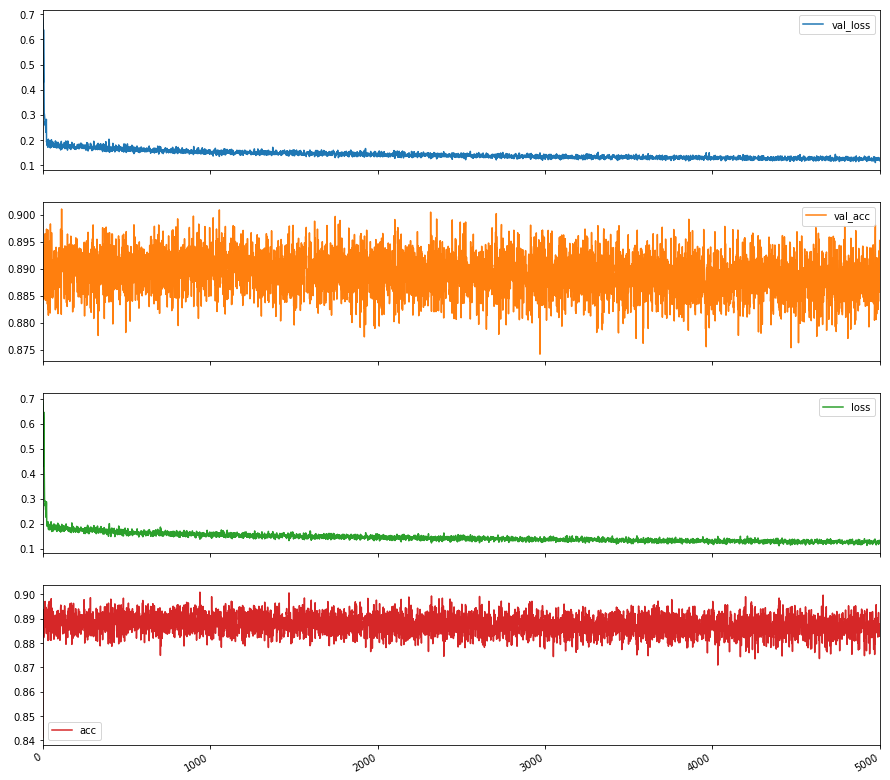

In [9]:
df_hist = pd.DataFrame(hist.history)
df_hist.plot(subplots=True, figsize=(15,15))
print(df_hist['val_loss'].min())
df_hist[df_hist['val_loss']<=0.1054]

##  Prediction

(3808, 64, 64, 1) (3808,)


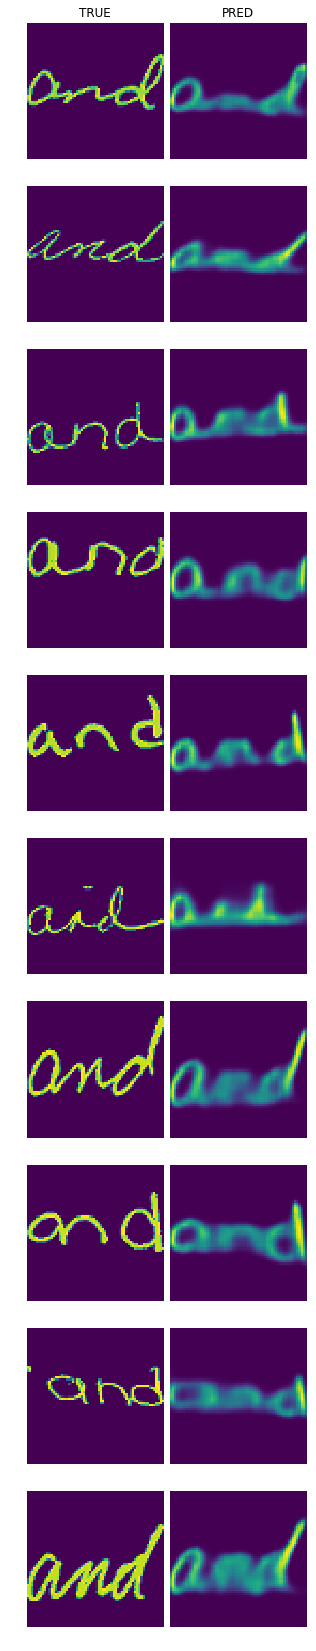

In [10]:
encoder = Model(inputs=autoencoder.inputs,outputs=autoencoder.get_layer('encoded').output)
test_g = datagen(len(val_list_of_writers)*4,val_path,val_list_of_writers, hshift = (-12,12), vis=True)
vx,vy = next(test_g)
print(vx.shape,vy[0].shape)
ids = vy[0].reshape(-1,1)
imagenames = vy[1].reshape(-1,1)
preds = encoder.predict(vx).reshape((-1,512))

data=[]
for i in range(len(vx)):
    data.append([ids[i][0],imagenames[i][0],preds[i]])
df_data = pd.DataFrame(data=data, columns=['identity','imagename','latent'])

py = autoencoder.predict(vx[:10])
f,ax = plt.subplots(len(vx[:10]),2)
f.subplots_adjust(hspace = .00, wspace=.05)
f.set_size_inches(5,len(vx[:10])*3)
ax[0,0].set_title('TRUE')
ax[0,1].set_title('PRED')
for i in range(len(vx[:10])):
#     print(vy[0][i], vy[1][i])
    ax[i,0].imshow(vx[i].reshape((64,64)))
    ax[i,0].axis('off')
    
    ax[i,1].imshow(py[i].reshape((64,64)))
    ax[i,1].axis('off')


In [11]:
cos_dist_out = cosine_similarity(list(df_data['latent'].values))
queried_count, idx_count, tp, tn, fp, fn = 0,0,0,0,0,0
cos_thresh = 0.63
data_result = []
fp_list = []
fn_list = []
r_counter = 0
stop_at = 10
prev_query = ''
prev_given = ''
given_count = 0
for row in tqdm(cos_dist_out):
    c_counter = 0
    given_idx = df_data.iloc[r_counter]['identity']
    given_img = df_data.iloc[r_counter]['imagename']
    for col in row:
        queried_idx = df_data.iloc[c_counter]['identity']
        queried_img = df_data.iloc[c_counter]['imagename']
        if int(given_idx) == int(queried_idx) and cos_dist_out[r_counter][c_counter]>cos_thresh:
            tp += 1
        if int(given_idx) != int(queried_idx) and cos_dist_out[r_counter][c_counter]<cos_thresh:
            tn += 1
        if int(given_idx) != int(queried_idx) and cos_dist_out[r_counter][c_counter]>cos_thresh:
            fp += 1
            fp_list.append(os.path.join(queried_idx,queried_img))
        if int(given_idx) == int(queried_idx) and cos_dist_out[r_counter][c_counter]<cos_thresh:
            fn += 1
            fn_list.append(os.path.join(queried_idx,queried_img))
        if int(given_idx) == int(queried_idx):
            idx_count += 1

        if prev_query != queried_idx:

            queried_count += 1
        c_counter += 1
        prev_query = queried_idx

    precision = tp/(fp+tp)
    recall = tp/(tp+fn)
    f1 = 2*(precision*recall)/(precision+recall)
    total = np.sum((tp,tn,fp,fn))
    accuracy = (tp+tn)/total
    data_result.append([given_idx,given_img, idx_count, tp, tn, fp, fn,precision,recall,f1,accuracy, total, fp_list, fn_list])
    if prev_given != given_idx:
        given_count+=1
    r_counter += 1
    prev_given = given_idx
    queried_count, idx_count, tp, tn, fp, fn = 0, 0, 0, 0, 0, 0
    fp_list = []
    fn_list = []

100%|██████████| 3808/3808 [1:02:14<00:00,  1.10it/s]


In [12]:
df_cos_dist_out = pd.DataFrame(data_result, columns=['identity','imagename','total_images_identity','TP','TN','FP','FN','precision','recall','f1','accuracy','total_images', 'FP_List','FN_List'])
df_cos_dist_out=df_cos_dist_out.sort_values(by='identity').reset_index().drop(columns=['index'])
df_cos_dist_out.to_csv('results_AutoEncoder_Seen.csv')

total = df_cos_dist_out.shape[0]
total_images_identity = df_cos_dist_out['total_images_identity']
tps = df_cos_dist_out['TP'].sum()
fps = df_cos_dist_out['FP'].sum()
tns = df_cos_dist_out['TN'].sum()
fns = df_cos_dist_out['FN'].sum()
precision = tps/(fps+tps)
recall = tps/(tps+fns)
f1 = 2*(precision*recall)/(precision+recall)
print('precision:',precision,'\nrecall:',recall,'\nf1:',f1)
acc = df_cos_dist_out['accuracy'].mean()
print('Intra Writer Accuracy (Type 1):',np.mean(df_cos_dist_out['TP']/total_images_identity))
print('Inter Writer Accuracy (Type 2)::',tns/total/total)
print('acc:',acc)

precision: 0.021011370912477113 
recall: 0.8449617077730206 
f1: 0.04100313112691306
Intra Writer Accuracy (Type 1): 0.8506304151648305
Inter Writer Accuracy (Type 2):: 0.9076678465503849
acc: 0.9096004210507757
